Image Classifier Part 2
~ MLP and Deep Convolutional Networks ~
===========================

In [139]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn

# Check if GPU is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

import numpy as np
import glob
import cv2

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

Running code @ cpu


## Fashion-MNIST

### 1.  MLP on extracted attributes

#### Data Preparation

* **Fashion-MNIST** is the equivalent of MNIST dataset for gray images with clothing items. 

* it contains 60k images made of 10 classes: T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

* train: 60k; test: 10k

* every image has 16 attributes extracted using first HOG, then PCA over it with 20PC, and last a selector with 80%


In [172]:
# Prepare data
import torch
from torch.utils.data import Dataset

# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 256  #@param
BATCH_SIZE_TEST = 256  #@param
NO_WORKERS = 0  #@param
SHUFFLE_DATA = True  #@param
NUM_CLASSES = 10  # @param

# General parameters
flag_batch_norm = 'ON'  # @param['ON', 'OFF']
flag_regularize = True     # @param['True', 'False'] {type:"raw"}

In [96]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensors
        self.targets = torch.tensor(labels, dtype=torch.long)  # Convert to PyTorch tensors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [173]:
# Load fashion attributes
train_images = np.load('data/fashion/X_train20_scaled.npy')
y_train = np.load('data/fashion/y_train.npy')
test_images = np.load('data/fashion/X_test20_scaled.npy')
y_test = np.load('data/fashion/y_test.npy')

# Normalize
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

# Create datasets
train_images = MyDataset(train_images, y_train)
test_images = MyDataset(test_images, y_test)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')

Size of training images torch.Size([60000, 16])
Size of training labels 60000
Size of test images torch.Size([10000, 16])
Size of test labels 10000


#### Visualize Images

In [99]:
MAX_IMAGES = 10

def gallery(images, label, title='Input images'):
    class_dict = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    images = images.reshape(60000, 28, 28)
    images = images.reshape(60000, 28, 28, 1)
    print(images.shape)
    num_frames, h, w, num_channels = images.shape
    num_frames = min(num_frames, MAX_IMAGES)
    ff, axes = plt.subplots(1, num_frames, figsize=(num_frames, 1), subplot_kw={'xticks': [], 
                                                                                'yticks': []})
    for i in range(0, num_frames):
        if num_channels == 3:
            axes[i].imshow(np.squeeze(images[i]))
        else:
            axes[i].imshow(np.squeeze(images[i]), cmap='gray')
        axes[i].set_title(class_dict[label[i]])
        plt.setp(axes[i].get_xticklabels(), visible=False)
        plt.setp(axes[i].get_yticklabels(), visible=False)
    ff.subplots_adjust(wspace=0.1)
    plt.show()

(60000, 784)
(60000, 28, 28, 1)


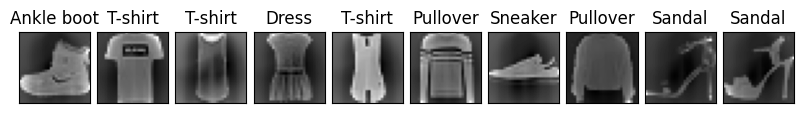

In [100]:
X_train = np.load('data/fashion/X_train.npy')
y_train = np.load('data/fashion/y_train.npy')
print(X_train.shape)
gallery(X_train, y_train)

#### Prepare Data

In [174]:
# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=SHUFFLE_DATA, 
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')


Shape of training images: torch.Size([256, 16])
Shape of training labels: torch.Size([256])


In [175]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=SHUFFLE_DATA, 
                                          num_workers=NO_WORKERS)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')


Shape of test images: torch.Size([256, 16])
Shape of test labels: torch.Size([256])


#### Define MLP

Architecture:
  * FC(16, 256) + ReLU
  * FC(256, 256) + ReLU
  * FC(256, 10)

In [105]:
class MLP(nn.Module):
    def __init__(self, num_classes=10, in_size=16):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(in_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Define Model and Evaluation Functions

In [176]:
net = None                       # type: nn.Module
mlp_net = MLP(num_classes=NUM_CLASSES)
    
mlp_net.train()               # Default after init is train
mlp_net = mlp_net.to(device)      # Move network to device

print(list(mlp_net.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)


MLP(
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)
tensor([[-0.1116,  0.0170, -0.0315, -0.2364, -0.0464, -0.1267,  0.0185, -0.2393,
         -0.1067, -0.0104],
        [-0.0913, -0.1250, -0.0262, -0.1826, -0.1532, -0.0434,  0.0519, -0.1562,
         -0.1039, -0.1839]], grad_fn=<AddmmBackward0>)
tensor([6, 6])
tensor([7, 7])


In [113]:
# Get number of parameters in a model by iterating through the model parameters
def get_num_params(model):
    num_params = 0
    for params in model.parameters():
        num_params += params.shape.numel()
        
    return num_params


In [177]:
# Get number of parameters in the model. Verify that we have implemented models correctly
print("Total number of parameters of models")
print(str(mlp_net.__class__), ": ", get_num_params(mlp_net))  

Total number of parameters of models
<class '__main__.MLP'> :  72714


In [115]:
def top_k_accuracy(k, target, output):
    batch_size = target.size(0)
    
    _, pred = output.topk(k, 1, True, True)
    
    pred = pred.t()
    correct = pred.eq(target.to(device).view(1, -1).expand_as(pred))

    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    correct_k.mul_(100.0 / batch_size)
    
    return correct_k


##### Define Optimizer

In [146]:
lr_init = 0.0001             # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-3  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

In [178]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.SGD(mlp_net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
# optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.SGD(mlp_net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    # optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

##### Accuracy and Loss Plotting

In [119]:
# Function that takes a list of losses and plots them.
REFRESH_EVERY = 1000

# Funcție pentru afișarea a două grafice: unul pentru eroare și unul pentru acuratețe
def plot_loss_and_accuracy_side_by_side(train_losses, test_losses, train_accuracies, test_accuracies, steps, ct):
    print(f'Step {ct}')
    
    # print all loss and accuracy
    if ct % REFRESH_EVERY == 0:
        display.clear_output(wait=True)
    
    display.display(plt.gcf())
    plt.clf()  # Șterge graficul anterior
    
    # Configurare subploturi
    _, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Graficul pentru pierderi (loss)
    axs[0].plot(steps, train_losses, c='b', label='Train Loss')  # Albastru pentru eroarea de antrenare
    axs[0].plot(steps, test_losses, c='r', label='Test Loss')    # Roșu pentru eroarea de test
    axs[0].set_title('Loss Over Steps')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    
    # Graficul pentru acuratețe (accuracy)
    axs[1].plot(steps, train_accuracies, c='b', linestyle='--', label='Train Accuracy')  # Albastru pentru acuratețea de antrenare
    axs[1].plot(steps, test_accuracies, c='r', linestyle='--', label='Test Accuracy')  # Roșu pentru acuratețea de test
    axs[1].set_title('Accuracy Over Steps')
    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='upper right')
    
    plt.tight_layout()  # Ajustează spațiile dintre subploturi
    plt.show()


##### Model Evaluation

In [38]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

# Funcție pentru calculul metricilor
def evaluate_model(net, loader, device):
    net.eval()  # Setăm modelul în modul de evaluare
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            preds = torch.argmax(outputs, axis=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculăm metricile
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    
    return precision, recall, f1, accuracy

# Date pentru diferite experimente
results = []

##### Define Training Parameters

In [92]:
# Define number of training iterations and reporting intervals
TRAIN_ITERS = 100e3  # @param
REPORT_TRAIN_EVERY = 100  # @param
PLOT_EVERY = 100  # @param
REPORT_TEST_EVERY = 100  # @param
TEST_ITERS = 100  # @param

#### Train and Evaluate Model

In [419]:
def train_mlp(train_dataset_size, batch_size_train, train_loader, test_loader, net, lr_scheduler, optimizer, epochs=200):
    train_iter = 0
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    steps = []

    # simulate an inifinte test data provider by looping over the test data
    test_data_provider = loopy_test_loader(test_loader)

    # set model in train mode
    net.train()

    running_loss = 0.0
    running_acc = 0.0
    ct = 0

    for epoch in range(int(epochs)):  # loop over the dataset multiple times
        
        for i, data in enumerate(train_loader, 0):
            # set the learning rate and decay according to iteration schedule
            lr_scheduler.step()
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += top_k_accuracy(1, labels, outputs)
            
            if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:    # print every REPORT_TRAIN_EVERY mini-batch iterations
                train_loss = running_loss / REPORT_TRAIN_EVERY
                train_acc = running_acc / REPORT_TRAIN_EVERY
                
                print('[%d, %5d, %6d] LR: %.5f' % (epoch + 1, i + 1, train_iter, lr_scheduler.get_lr()[-1]))
                print('[%d, %5d] loss: %.5f, acc: %.5f' %
                    (epoch + 1, i + 1, train_loss, train_acc))
                
                train_losses.append(train_loss)
                train_accuracy.append(train_acc.item())
                steps.append(train_iter)
                
                running_loss = 0
                train_loss = 0
                train_acc = 0
                running_acc = 0
                
            if train_iter % PLOT_EVERY == 0:
                # plot_losses(losses, acc, steps, train_iter)
                plot_loss_and_accuracy_side_by_side(train_losses, test_losses, train_accuracy, test_accuracy, steps, train_iter)
                
            train_iter += 1
        
            if train_iter % REPORT_TEST_EVERY == 0:
                # set model in test mode
                net.eval()
                
                with torch.no_grad():
                    # evaluate over at most TEST_ITER sub samples from the test_loader
                    test_iter = 0
                    test_loss = 0
                    correct = 0
                    
                    while test_iter < TEST_ITERS:
                    # for j, test_data in enumerate(test_loader, start=test_ct):
                        test_data = next(test_data_provider)
                            
                        # get the test inputs; data is a list of [inputs, labels]
                        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
                        
                        out = net(test_inputs)
                        test_loss += criterion(out, test_labels)
                        
                        
                        correct += top_k_accuracy(1, test_labels, out)
                        
                        test_iter += 1
                        
                    avg_test_loss = test_loss / TEST_ITERS
                    avg_acc = correct / TEST_ITERS

                    test_losses.append(avg_test_loss.item())
                    test_accuracy.append(avg_acc.item())
                    
                    print('[%d, %5d] avg_test_loss: %.5f, avg_test_acc: %.2f' 
                        % (epoch + 1, i + 1, avg_test_loss, avg_acc))
                    
                # set model back in train mode
                net.train()

    print('Finished Training')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

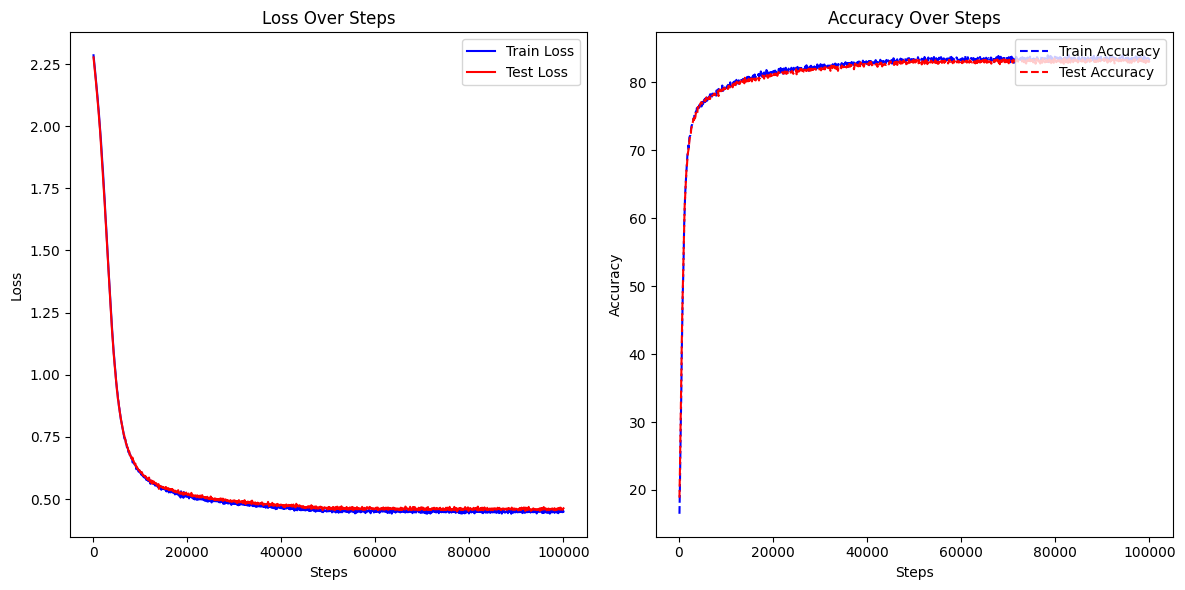

[426,   225, 100099] LR: 0.00000
[426,   225] loss: 0.44552, acc: 83.53516
[426,   225] avg_test_loss: 0.45428, avg_test_acc: 83.32
Step 100100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

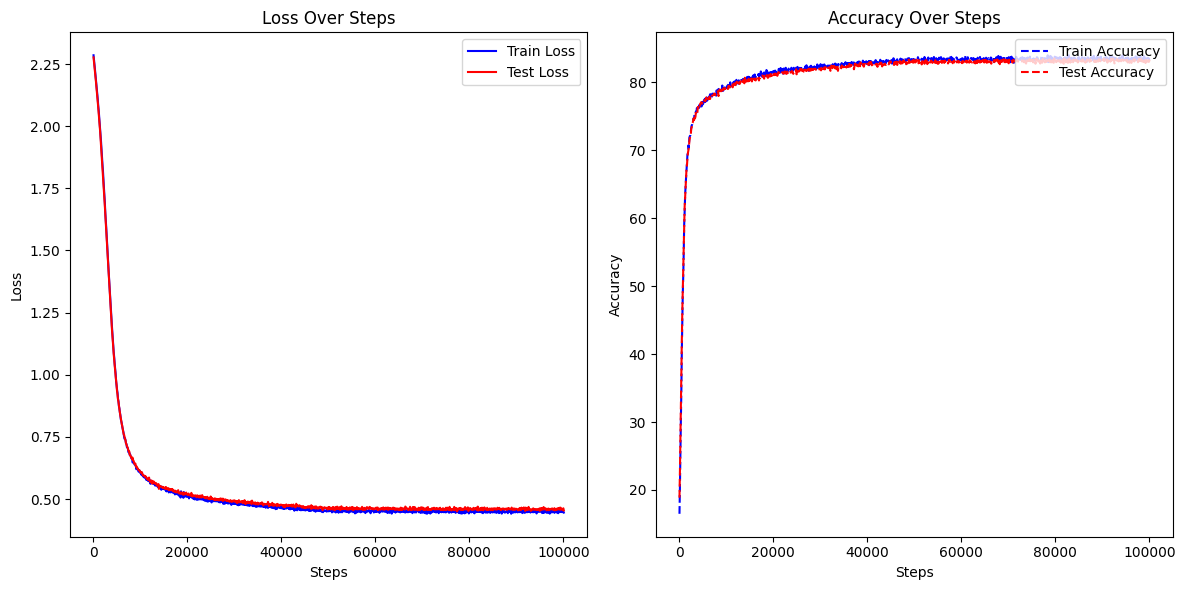

Finished Training


In [179]:
train_mlp(60000, BATCH_SIZE_TRAIN, train_loader=train_loader, test_loader=test_loader,
         net=mlp_net, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [181]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fashion-MNIST"
input_type = "HOG-PCA20 Attributes"
model_name = "MLP"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(mlp_net, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(mlp_net, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,LeNet-5,Test,0.888863,0.888100,0.888339,0.888100
Fashion-MNIST,Liniarized Images,MLP,Test,0.860365,0.861300,0.860445,0.861300
Fashion-MNIST,HOG-PCA20 Attributes,MLP,Test,0.830739,0.831500,0.830838,0.831500


In [182]:
results_df.to_csv('results.csv', index=False)

### 2. MLP on Images

#### Load Data

In [161]:
# Load fashion attributes
train_images = np.load('data/fashion/X_train.npy')
y_train = np.load('data/fashion/y_train.npy')
test_images = np.load('data/fashion/X_test.npy')
y_test = np.load('data/fashion/y_test.npy')

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_images)
X_test = scaler.transform (test_images)

# Create datasets
train_images = MyDataset(train_images, y_train)
test_images = MyDataset(test_images, y_test)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')

Size of training images torch.Size([60000, 784])
Size of training labels 60000
Size of test images torch.Size([10000, 784])
Size of test labels 10000


In [162]:
# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
BATCH_SIZE_TEST = 256
BATCH_SIZE_TRAIN = 256
train_loader = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=SHUFFLE_DATA, 
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

Shape of training images: torch.Size([256, 784])
Shape of training labels: torch.Size([256])


In [163]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=SHUFFLE_DATA, 
                                          num_workers=NO_WORKERS)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')

Shape of test images: torch.Size([256, 784])
Shape of test labels: torch.Size([256])


#### Define Model and Optimizer

In [164]:
net = None                       # type: nn.Module
mlp_net2 = MLP(num_classes=NUM_CLASSES, in_size=(28 * 28))
    
mlp_net2.train()               # Default after init is train
mlp_net2 = mlp_net2.to(device)      # Move network to device

print(list(mlp_net2.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_net2(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)


MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)
tensor([[-0.1316,  0.0013, -0.0824,  0.1356,  0.0131,  0.0725,  0.1320, -0.0060,
         -0.0932, -0.0149],
        [-0.0970,  0.0131, -0.1449,  0.1071,  0.0414,  0.1215,  0.0834, -0.0705,
         -0.0375, -0.0171]], grad_fn=<AddmmBackward0>)
tensor([3, 5])
tensor([0, 0])


In [165]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.SGD(mlp_net2.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
# optimizer = torch.optim.Adam(mlp_net2.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.SGD(mlp_net2.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    # optimizer = torch.optim.Adam(mlp_net2.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

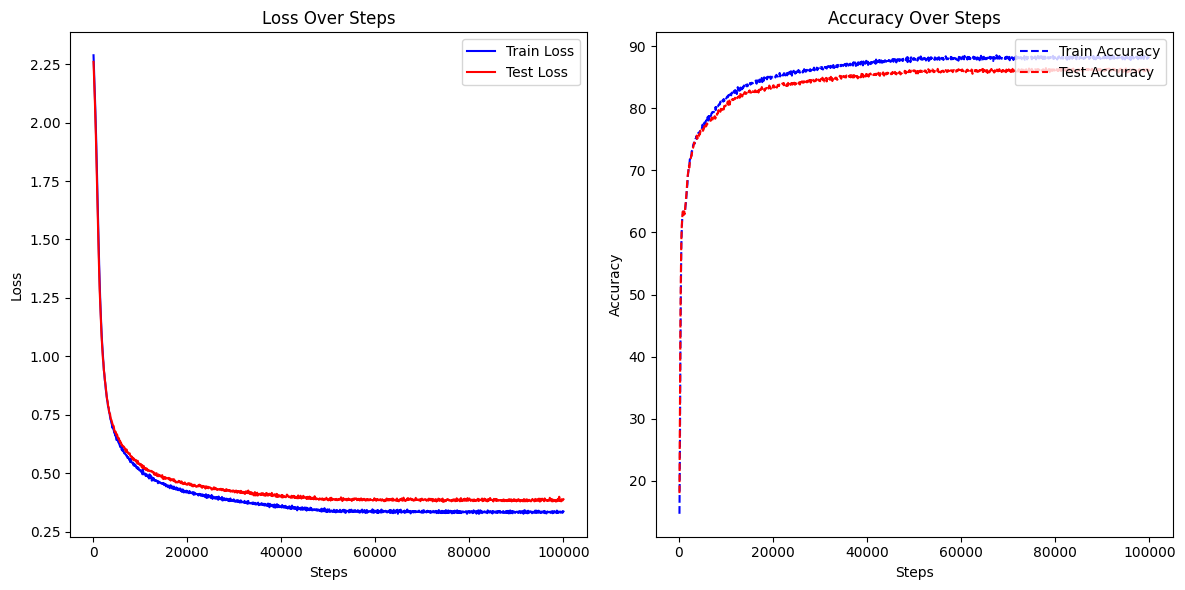

[426,   225, 100099] LR: 0.00000
[426,   225] loss: 0.32921, acc: 88.35156
[426,   225] avg_test_loss: 0.38161, avg_test_acc: 86.20
Step 100100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

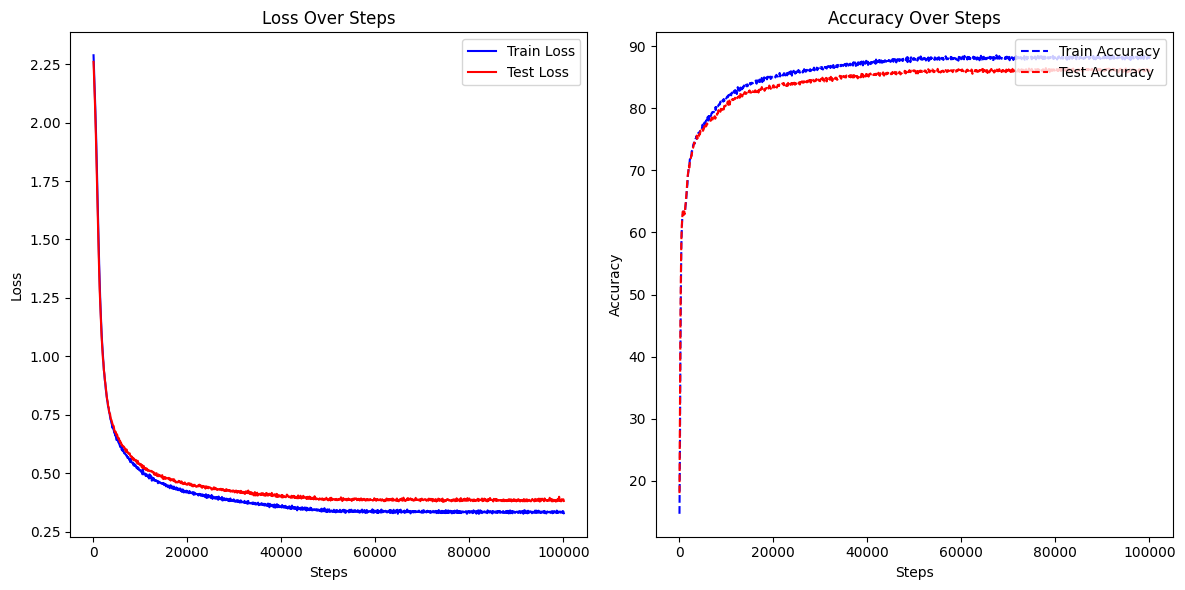

Finished Training


In [167]:
train_mlp(60000, BATCH_SIZE_TRAIN, train_loader=train_loader, test_loader=test_loader,
         net=mlp_net2, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [169]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fashion-MNIST"
input_type = "Liniarized Images"
model_name = "MLP"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(mlp_net2, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(mlp_net2, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,LeNet-5,Test,0.888863,0.888100,0.888339,0.888100
Fashion-MNIST,Liniarized Images,MLP,Test,0.860365,0.861300,0.860445,0.861300


In [170]:
results_df.to_csv('results.csv', index=False)

### 3. DeepConvNet on Images

#### Load Data

In [157]:
# Load fashion attributes
train_images = np.load('data/fashion/X_train.npy')
y_train = np.load('data/fashion/y_train.npy')
test_images = np.load('data/fashion/X_test.npy')
y_test = np.load('data/fashion/y_test.npy')

# # Normalize the data
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

# Resize the images to 28x28
train_images = train_images.reshape(-1, 1, 28, 28)
test_images = test_images.reshape(-1, 1, 28, 28)

# Create datasets
train_images = MyDataset(train_images, y_train)
test_images = MyDataset(test_images, y_test)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')

# Verify normalization
print(f'Min pixel value (train): {train_images.data.min()}, Max pixel value (train): {train_images.data.max()}')
print(f'Min pixel value (test): {test_images.data.min()}, Max pixel value (test): {test_images.data.max()}')

Size of training images torch.Size([60000, 1, 28, 28])
Size of training labels 60000
Size of test images torch.Size([10000, 1, 28, 28])
Size of test labels 10000
Min pixel value (train): -2.410065174102783, Max pixel value (train): 185.47760009765625
Min pixel value (test): -2.420701503753662, Max pixel value (test): 99.31272888183594


In [158]:
# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
BATCH_SIZE_TRAIN = 256
train_loader = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=SHUFFLE_DATA, 
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

Shape of training images: torch.Size([256, 1, 28, 28])
Shape of training labels: torch.Size([256])


In [159]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=SHUFFLE_DATA, 
                                          num_workers=NO_WORKERS)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')

Shape of test images: torch.Size([256, 1, 28, 28])
Shape of test labels: torch.Size([256])


#### Define DeepConvNet Architecture

In [41]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            nn.Dropout2d(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.Linear(in_features=120, out_features=10)
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

In [75]:
# model
net = None                       # type: nn.Module
net = LeNet()
    
net.train()               # Default after init is train
net = net.to(device)      # Move network to device

print(list(net.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

LeNet(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=120, out_features=10, bias=True)
  )
)
tensor([[ 0.0142,  0.0174,  0.0549,  0.0772,  0.0298, -0.0039, -0.0086,  0.0781,
         -0.0861, -0.0359],
        [ 0.0158,  0.0102,  0.0622,  0.0743,  0.0316, -0.0010, -0.0024,  0.0697,
         -0.0829, -0.0345]], grad_fn=<AddmmBackward0>)
tensor([7, 3])
tensor([7, 8])


In [76]:
lr_init = 0.001             # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-4  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.Adam(net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.Adam(net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate

In [81]:
def train_lenet(train_dataset_size, batch_size_train, train_loader, test_loader, net, lr_scheduler, optimizer):
    epochs = int(TRAIN_ITERS / (train_dataset_size / batch_size_train))

    train_iter = 0
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    steps = []

    # simulate an inifinte test data provider by looping over the test data
    test_data_provider = loopy_test_loader(test_loader)

    # set model in train mode
    net.train()

    running_loss = 0.0
    running_acc = 0.0
    ct = 0

    for epoch in range(int(epochs)):  # loop over the dataset multiple times
        
        for i, data in enumerate(train_loader, 0):
            # set the learning rate and decay according to iteration schedule
            lr_scheduler.step()
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += top_k_accuracy(1, labels, outputs)
            
            if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:    # print every REPORT_TRAIN_EVERY mini-batch iterations
                train_loss = running_loss / REPORT_TRAIN_EVERY
                train_acc = running_acc / REPORT_TRAIN_EVERY
                
                print('[%d, %5d, %6d] LR: %.5f' % (epoch + 1, i + 1, train_iter, lr_scheduler.get_lr()[-1]))
                print('[%d, %5d] loss: %.5f, acc: %.5f' %
                    (epoch + 1, i + 1, train_loss, train_acc))
                
                train_losses.append(train_loss)
                train_accuracy.append(train_acc.item())
                steps.append(train_iter)
                
                running_loss = 0
                train_loss = 0
                train_acc = 0
                running_acc = 0
                
            if train_iter % PLOT_EVERY == 0:
                # plot_losses(losses, acc, steps, train_iter)
                plot_loss_and_accuracy_side_by_side(train_losses, test_losses, train_accuracy, test_accuracy, steps, train_iter)
                
            train_iter += 1
        
            if train_iter % REPORT_TEST_EVERY == 0:
                # set model in test mode
                net.eval()
                
                with torch.no_grad():
                    # evaluate over at most TEST_ITER sub samples from the test_loader
                    test_iter = 0
                    test_loss = 0
                    correct = 0
                    
                    while test_iter < TEST_ITERS:
                    # for j, test_data in enumerate(test_loader, start=test_ct):
                        test_data = next(test_data_provider)
                            
                        # get the test inputs; data is a list of [inputs, labels]
                        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
                        
                        out = net(test_inputs)
                        test_loss += criterion(out, test_labels)
                        
                        
                        correct += top_k_accuracy(1, test_labels, out)
                        
                        test_iter += 1
                        
                    avg_test_loss = test_loss / TEST_ITERS
                    avg_acc = correct / TEST_ITERS

                    test_losses.append(avg_test_loss.item())
                    test_accuracy.append(avg_acc.item())
                    
                    print('[%d, %5d] avg_test_loss: %.5f, avg_test_acc: %.2f' 
                        % (epoch + 1, i + 1, avg_test_loss, avg_acc))
                    
                # set model back in train mode
                net.train()

    print('Finished Training')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

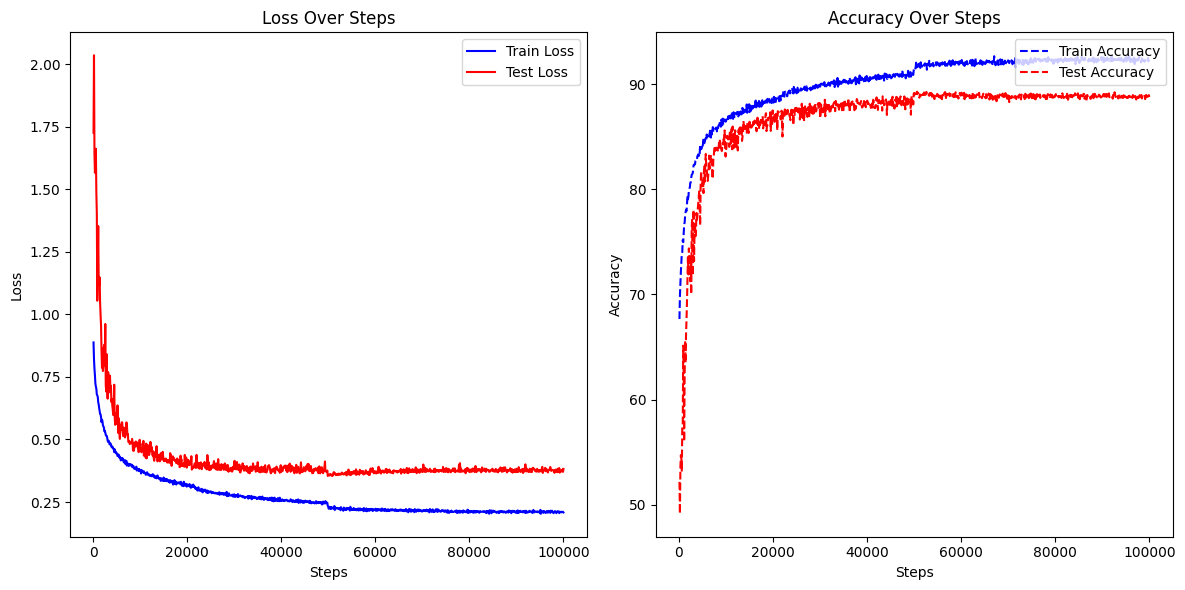

[426,   225, 100099] LR: 0.00000
[426,   225] loss: 0.21239, acc: 92.37500
[426,   225] avg_test_loss: 0.37364, avg_test_acc: 88.84
Step 100100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

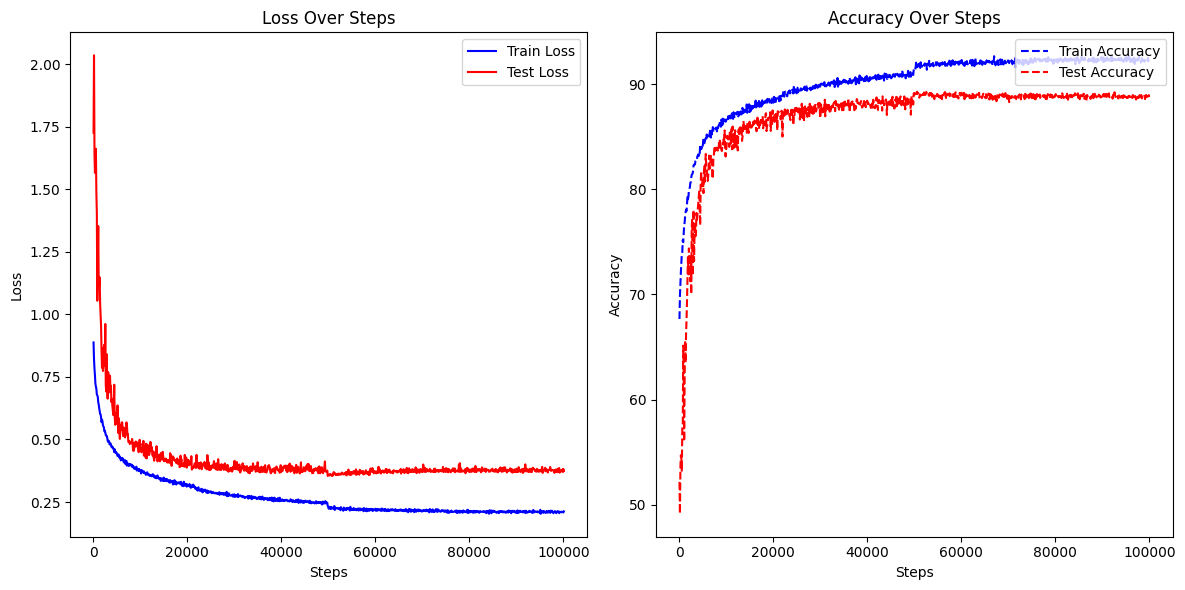

Finished Training


In [84]:
train_lenet(60000, 256, train_loader=train_loader, test_loader=test_loader,
         net=net, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [85]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fashion-MNIST"
input_type = "Liniarized Images"
model_name = "LeNet-5"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(net, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(net, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,LeNet-5,Test,0.888863,0.888100,0.888339,0.888100


In [86]:
# saving the dataframe
results_df.to_csv('LeNet-5.csv')

### 4. Finetuning on Trained Models

In [190]:
# Author: Sasank Chilamkurthy

import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory
from PyTorch_CIFAR10.cifar10_models.resnet import resnet18

cudnn.benchmark = True
plt.ion()   # interactive mode

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Load Data

In [349]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),     # Convert to tensor and scale to [0, 1]
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel 3 times
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])  # Normalize for RGB channels
])

# Load the dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataset.data = train_dataset.data
train_dataset.targets = train_dataset.targets
test_dataset.data = test_dataset.data
test_dataset.targets = test_dataset.targets

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Test the output
images, labels = next(iter(train_loader))
print(images.size())
print(labels.size())

images, labels = next(iter(test_loader))
print(images.size())
print(labels.size())

torch.Size([256, 3, 32, 32])
torch.Size([256])
torch.Size([256, 3, 32, 32])
torch.Size([256])


In [351]:
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
print(dataset_sizes)

{'train': 60000, 'val': 10000}


#### Visualize Images

Batch shape: torch.Size([500, 3, 32, 32])
Classes shape: torch.Size([500])
Input shape before transpose: torch.Size([1, 36, 274])


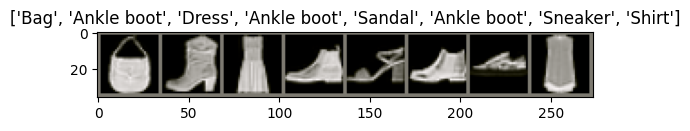

In [283]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    print(f"Input shape before transpose: {inp.shape}")
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    
    # Use the correct mean and std
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2471, 0.2435, 0.2616])
    
    # Reverse normalization
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # Clip values to [0, 1] for display
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))  # Use your actual train_loader here

# Make a grid from batch
print(f"Batch shape: {inputs.shape}")
print(f"Classes shape: {classes.shape}")
out = torchvision.utils.make_grid(inputs[:8])

# Display the images
imshow(out[:1], title=[class_names[x] for x in classes[:8]])


#### Training the Model

In [358]:
train_loss_fn = []
val_loss_fn = []
train_acc_fn = []
val_acc_fn = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    train_loss_fn.append(epoch_loss)
                    train_acc_fn.append(epoch_acc)
                else:
                    val_loss_fn.append(epoch_loss)
                    val_acc_fn.append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    # Save accuracies and losses
    np.save('train_loss_fn.npy', train_loss_fn)
    np.save('val_loss_fn.npy', val_loss_fn)
    np.save('train_acc_fn.npy', train_acc_fn)
    np.save('val_acc_fn.npy', val_acc_fn)
    return model

#### Visualize predictions

In [360]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Finetuning the ConvNet

In [364]:
# Pretrained model
resnet18_model = resnet18(pretrained=True) 
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = resnet18_model.to(device)

lr_init = 0.001              # initial learning rate
lr_factor = 0.01             # learning rate decay factor
weight_decay_factor = 1e-4   # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate Model

In [365]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.1021 Acc: 0.7260
val Loss: 0.5568 Acc: 0.8607

Epoch 1/19
----------
train Loss: 0.3837 Acc: 0.9104
val Loss: 0.3207 Acc: 0.9091

Epoch 2/19
----------
train Loss: 0.2354 Acc: 0.9362
val Loss: 0.2889 Acc: 0.9080

Epoch 3/19
----------
train Loss: 0.1847 Acc: 0.9469
val Loss: 0.2354 Acc: 0.9235

Epoch 4/19
----------
train Loss: 0.1512 Acc: 0.9539
val Loss: 0.2701 Acc: 0.9136

Epoch 5/19
----------
train Loss: 0.1207 Acc: 0.9643
val Loss: 0.2348 Acc: 0.9243

Epoch 6/19
----------
train Loss: 0.1002 Acc: 0.9699
val Loss: 0.2348 Acc: 0.9278

Epoch 7/19
----------
train Loss: 0.0881 Acc: 0.9746
val Loss: 0.2425 Acc: 0.9264

Epoch 8/19
----------
train Loss: 0.0748 Acc: 0.9782
val Loss: 0.2132 Acc: 0.9380

Epoch 9/19
----------
train Loss: 0.0595 Acc: 0.9832
val Loss: 0.2622 Acc: 0.9237

Epoch 10/19
----------
train Loss: 0.0520 Acc: 0.9853
val Loss: 0.2384 Acc: 0.9305

Epoch 11/19
----------
train Loss: 0.0463 Acc: 0.9873
val Loss: 0.2487 Acc: 0.9298

Ep

Step 20


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

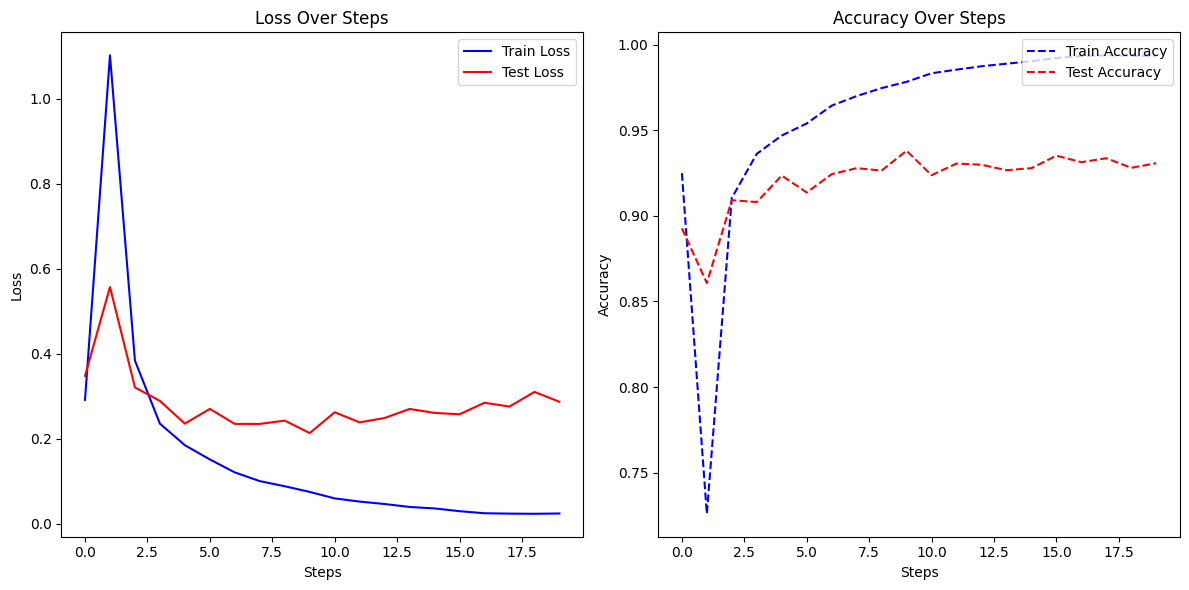

In [375]:
plot_loss_and_accuracy_side_by_side(train_loss_fn[:20], val_loss_fn[:20], train_acc_fn[:20], val_acc_fn[:20], range(20), 20)

In [376]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fashion-MNIST"
input_type = "Liniarized Images"
model_name = "Finetuned ResNet18"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(model_ft, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(model_ft, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

Dataset,Input Type,Model,Data Split,Precision,Recall,F1 Score,Accuracy
Fashion-MNIST,Liniarized Images,LeNet-5,Test,0.888863,0.888100,0.888339,0.888100
Fashion-MNIST,Liniarized Images,MLP,Test,0.860365,0.861300,0.860445,0.861300
Fashion-MNIST,HOG-PCA20 Attributes,MLP,Test,0.830739,0.831500,0.830838,0.831500
Fashion-MNIST,Liniarized Images,Finetuned ResNet18,Test,0.937816,0.938000,0.937773,0.938000


In [377]:
results_df.to_csv('results.csv', index=False)

## Fruits-360

* **Fruits-360** is a dataset containing classes of fruits, vegetables, and nuts

* it contains 95k images made of 70 classes

* train: 71k; test: 24k

* every image has 70 attributes extracted using PCA with 70PC

In [385]:
import gc
import cv2

### 1. MLP on extracted attributes

#### Load Data

In [378]:
def getAllFruits():
    fruits = np.load('data/fruits-360/all_fruits.npy', allow_pickle=True)
    return fruits

fruits = getAllFruits()
print(fruits)

['Mangostan' 'Cherry' 'Grape' 'Nectarine' 'Kohlrabi' 'Physalis' 'Carrot'
 'Melon' 'Tomato' 'Potato' 'Apple' 'Beetroot' 'Chestnut' 'Avocado' 'Pear'
 'Grapefruit' 'Kiwi' 'Nut' 'Cauliflower' 'Guava' 'Mulberry' 'Walnut'
 'Pineapple' 'Cucumber' 'Limes' 'Fig' 'Pepper' 'Onion' 'Kaki' 'Redcurrant'
 'Apricot' 'Banana' 'Peach' 'Zucchini' 'Granadilla' 'Maracuja'
 'Cantaloupe' 'Eggplant' 'Strawberry' 'Plum' 'Corn' 'Papaya' 'Mandarine'
 'Rambutan' 'Blueberry' 'Raspberry' 'Mango' 'Pitahaya' 'Tamarillo'
 'Cactus' 'Clementine' 'Huckleberry' 'Kumquats' 'Lemon' 'Hazelnut'
 'Quince' 'Dates' 'Watermelon' 'Cabbage' 'Pomelo' 'Carambula' 'Tangelo'
 'Cocos' 'Pepino' 'Pomegranate' 'Orange' 'Salak' 'Ginger' 'Passion'
 'Lychee']


In [496]:
# Load the dataset
train_images = np.load(f'./data/fruits-360/X_train_pca.npy')
test_images = np.load(f'./data/fruits-360/X_test_pca.npy')
y_train = np.load(f'./data/fruits-360/y_train.npy')
y_test = np.load(f'./data/fruits-360/y_test.npy')

# Normalize the data
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

# Create datasets
train_images = MyDataset(train_images, y_train)
test_images = MyDataset(test_images, y_test)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')

Size of training images torch.Size([71773, 70])
Size of training labels 71773
Size of test images torch.Size([24051, 70])
Size of test labels 24051


In [497]:
# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_images, batch_size=256, shuffle=True)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=256, shuffle=False)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')


Shape of training images: torch.Size([256, 70])
Shape of training labels: torch.Size([256])
Shape of test images: torch.Size([256, 70])
Shape of test labels: torch.Size([256])


#### Define Model and Optimizers

In [499]:
net = None                       # type: nn.Module
mlp_model = MLP(num_classes=len(fruits), in_size=70)
    
mlp_model.train()               # Default after init is train
mlp_model = mlp_model.to(device)      # Move network to device

print(list(mlp_model.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_model(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

MLP(
  (fc1): Linear(in_features=70, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=70, bias=True)
  (relu): ReLU(inplace=True)
)
tensor([[ 0.0278,  0.0317,  0.1002, -0.0318, -0.1326,  0.0152, -0.1449,  0.0096,
         -0.0645, -0.1034,  0.1003, -0.0271,  0.0166,  0.0225,  0.1015,  0.1117,
         -0.1276,  0.1677, -0.0647, -0.0088, -0.1132, -0.0005,  0.0292,  0.0043,
          0.0030, -0.1109, -0.0202,  0.0133,  0.0266, -0.1590, -0.0630,  0.0781,
          0.0327, -0.0235, -0.0403,  0.1431,  0.0209,  0.1938,  0.1445,  0.0950,
         -0.0519,  0.0911, -0.0668,  0.0856,  0.0939, -0.0472,  0.1116, -0.0707,
          0.0260,  0.2116,  0.0774, -0.0911,  0.0796,  0.0682,  0.0028,  0.0608,
          0.0502,  0.0586,  0.1128, -0.0268,  0.0850,  0.0171, -0.1189, -0.0033,
          0.0669, -0.2338,  0.0099,  0.1335, -0.0640,  0.1761],
        [-0.0489, -0.1245,  0.2143, -0.0243, -0.1680, -0.0650, -0.16

In [500]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
# optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.SGD(mlp_model.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    # optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Test and Evaluate

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

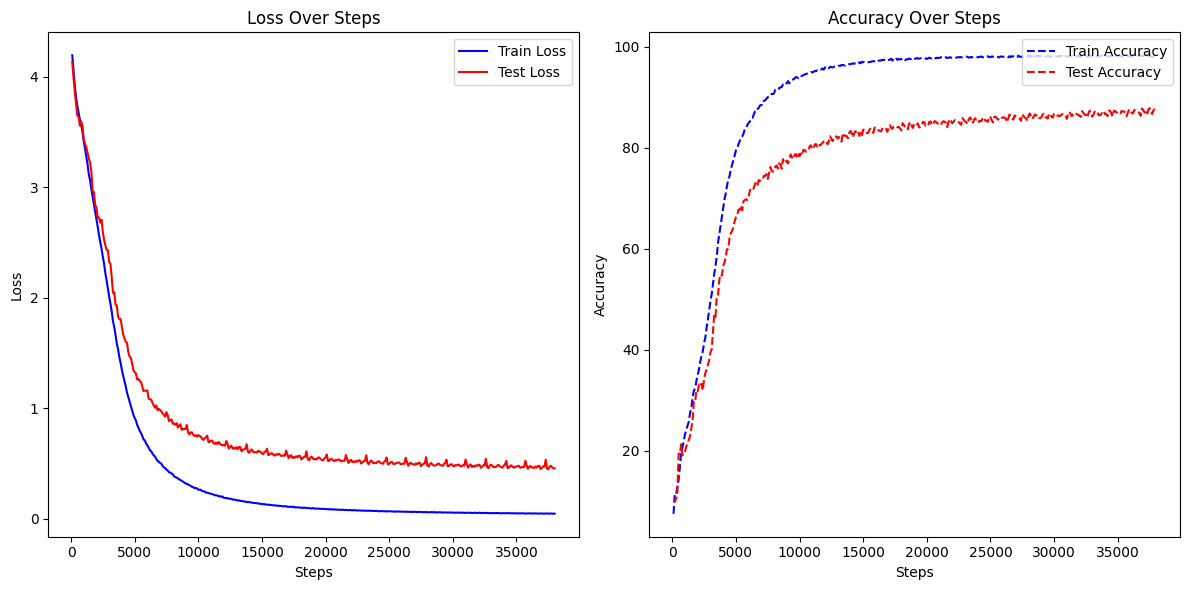

[136,   165,  38099] LR: 0.00100
[136,   165] loss: 0.04607, acc: 98.01172
[136,   165] avg_test_loss: 0.45794, avg_test_acc: 87.53
Step 38100


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

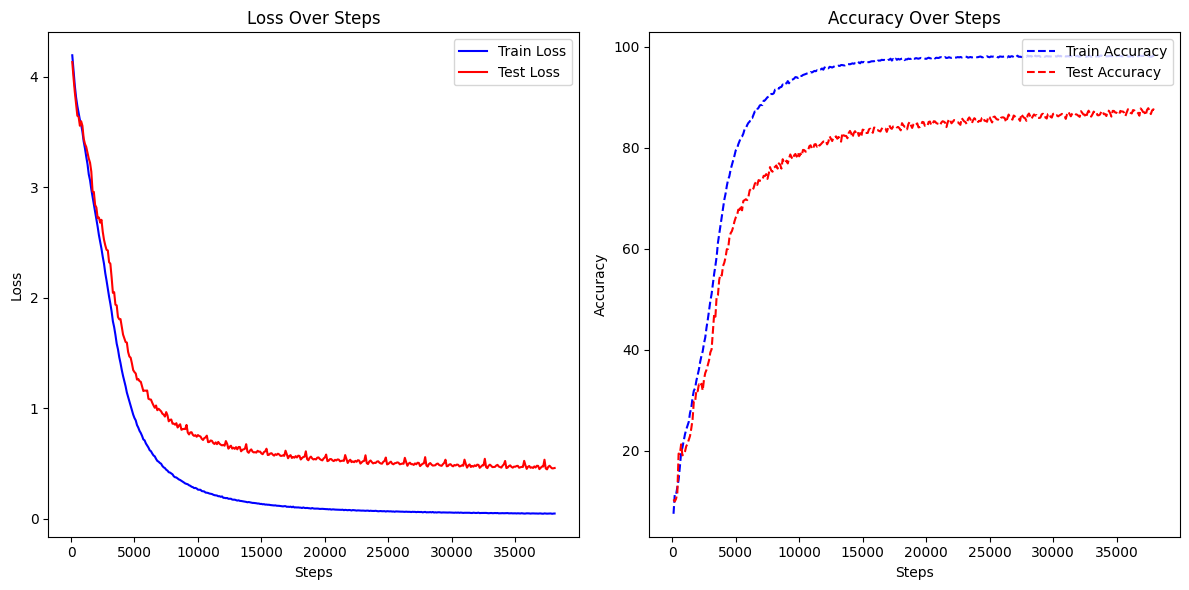

[136,   265,  38199] LR: 0.00100
[136,   265] loss: 0.04315, acc: 98.17578
[136,   265] avg_test_loss: 0.46907, avg_test_acc: 86.87
Step 38200


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

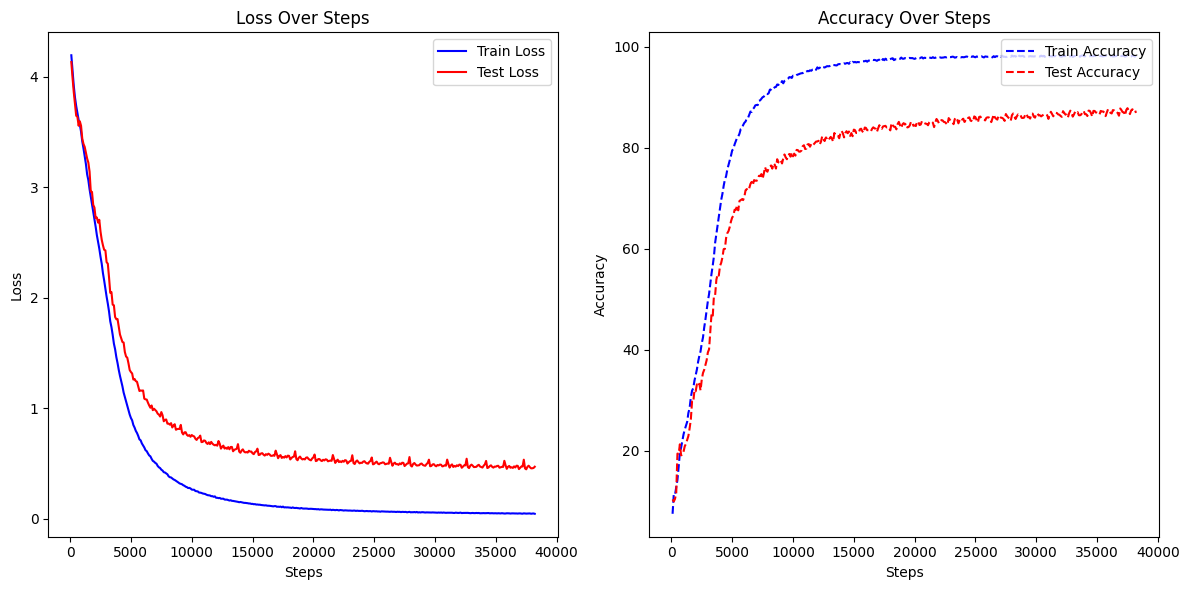

[137,    84,  38299] LR: 0.00100
[137,    84] loss: 0.04409, acc: 98.16113
[137,    84] avg_test_loss: 0.47578, avg_test_acc: 86.96
Step 38300


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

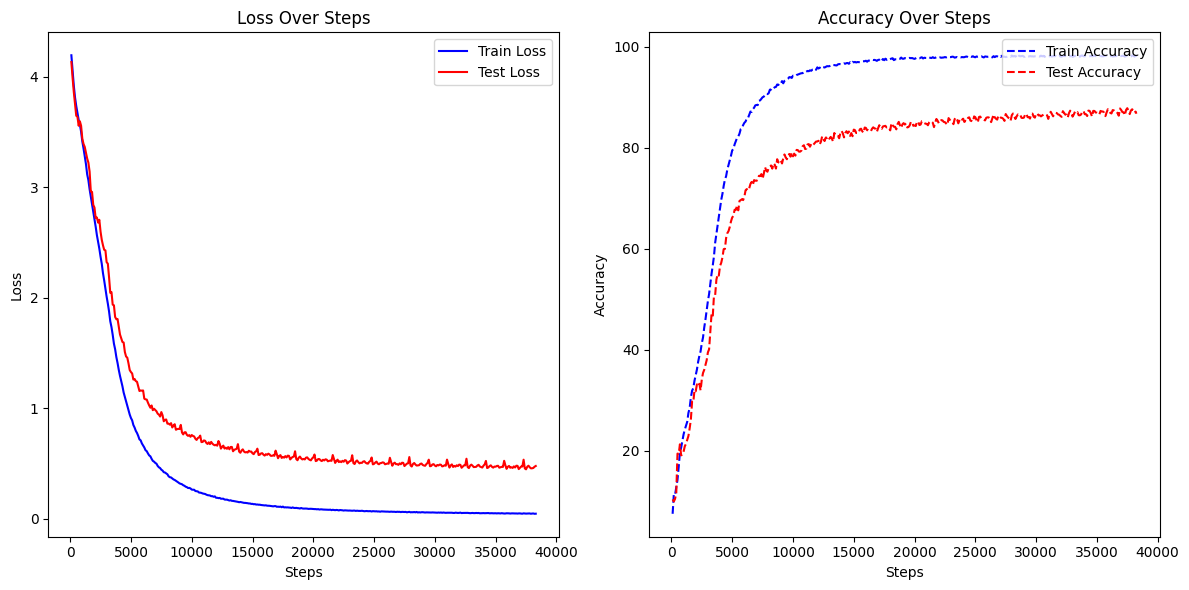

[137,   184,  38399] LR: 0.00100
[137,   184] loss: 0.04470, acc: 98.08984
[137,   184] avg_test_loss: 0.46269, avg_test_acc: 86.86
Step 38400


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

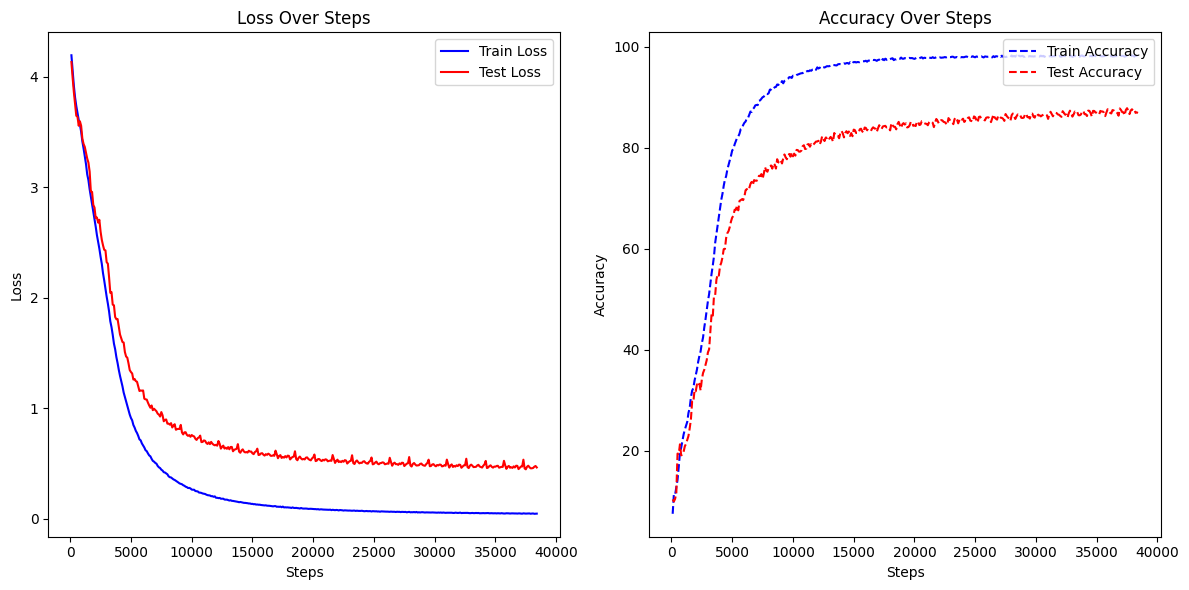

In [ ]:
train_mlp(71773, 256, train_loader=train_loader, test_loader=test_loader,
        net=mlp_model, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [ ]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fruits-360"
input_type = "PCA70 Extracted Attributes"
model_name = "MLP"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(mlp_model, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(mlp_model, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

In [ ]:
results_df.to_csv('results2.csv', index=False)

### 2. MLP on images

#### Rescale images to 32x32

In [446]:
# Scale images from 100x100 to 32x32
def resize_images(images, new_size=(32, 32)):
    resized_images = np.zeros((images.shape[0], new_size[0], new_size[1], images.shape[3]), dtype=np.uint8)
    for i in range(images.shape[0]):
        resized_image = cv2.resize(images[i].astype(np.uint8), new_size, interpolation=cv2.INTER_AREA)
        resized_images[i] = resized_image
    return resized_images

for fruit in fruits:
    # Paths for training and testing directories
    train_dir = f'./data/fruits-360/train/{fruit}'
    test_dir = f'./data/fruits-360/test/{fruit}'

    # Create directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Process training images ~
    X_train = np.load(f'./data/fruits-360/{fruit}_X_t.npy')
    X_train_resized = resize_images(X_train)
    print(f'{fruit} training images shape: {X_train_resized.shape}')
    
    # Save resized training images
    for idx, img in enumerate(X_train_resized):
        cv2.imwrite(os.path.join(train_dir, f'{fruit}_{idx}.jpg'), img)

    # Process testing images ~
    X_test = np.load(f'./data/fruits-360/{fruit}_X_testt.npy')
    X_test_resized = resize_images(X_test)
    print(f'{fruit} testing images shape: {X_test_resized.shape}')
    
    # Save resized testing images
    for idx, img in enumerate(X_test_resized):
        cv2.imwrite(os.path.join(test_dir, f'{fruit}_{idx}.jpg'), img)

    print(f'{fruit} images resized and saved in {train_dir} and {test_dir}')
    
    # Cleanup
    del X_train, X_train_resized, X_test, X_test_resized
    gc.collect()

Mangostan training images shape: (300, 32, 32, 3)
Mangostan testing images shape: (102, 32, 32, 3)
Mangostan images resized and saved in ./data/fruits-360/train/Mangostan and ./data/fruits-360/test/Mangostan
Cherry training images shape: (3444, 32, 32, 3)
Cherry testing images shape: (1148, 32, 32, 3)
Cherry images resized and saved in ./data/fruits-360/train/Cherry and ./data/fruits-360/test/Cherry
Grape training images shape: (4401, 32, 32, 3)
Grape testing images shape: (1476, 32, 32, 3)
Grape images resized and saved in ./data/fruits-360/train/Grape and ./data/fruits-360/test/Grape
Nectarine training images shape: (972, 32, 32, 3)
Nectarine testing images shape: (324, 32, 32, 3)
Nectarine images resized and saved in ./data/fruits-360/train/Nectarine and ./data/fruits-360/test/Nectarine
Kohlrabi training images shape: (471, 32, 32, 3)
Kohlrabi testing images shape: (157, 32, 32, 3)
Kohlrabi images resized and saved in ./data/fruits-360/train/Kohlrabi and ./data/fruits-360/test/Kohlr

#### Visualize Data

In [392]:
# Dataset image visualization
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1

['Mangostan' 'Cherry' 'Grape' 'Nectarine' 'Kohlrabi' 'Physalis' 'Carrot'
 'Melon' 'Tomato' 'Potato']


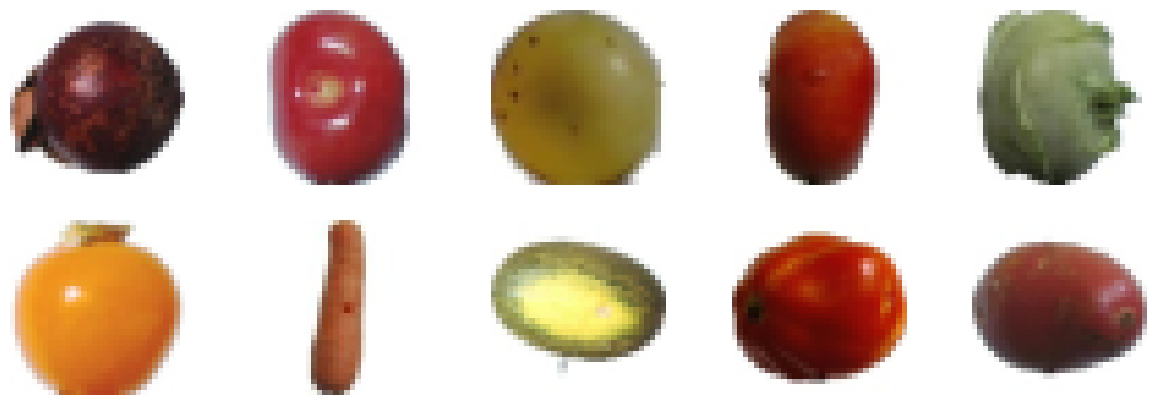

In [399]:
# Image plotting
images = []
fruits = getAllFruits()

images = []
for fruit in fruits[:10]:
    X_train = np.load(f'./data/fruits-360/{fruit}_X_train_resized.npy')
    images.append(X_train[0])
    del X_train

print(fruits[:10])
images = np.reshape(images, (len(fruits[:10]), 32, 32, 3))
plot_image_grid(images, 2, 5, figsize=(15, 5))
del images

#### Prepare Data

In [478]:
from torchvision import datasets, transforms

# Replace DATA_MEAN and DATA_STD with the calculated values
DATA_MEAN = (0.5, 0.5, 0.5)		# define the mean for the scaling transform - PIL images already come given in 
DATA_STD = (0.5, 0.5, 0.5)		# define the standard deviation for the scaling transform
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEAN, DATA_STD),      # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std 
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image to a 1D tensor
    ] 
)


test_transform = transforms.Compose(
    [
        transforms.ToTensor(),                          # on test set we only need to apply the same normalization
        transforms.Normalize(DATA_MEAN, DATA_STD),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image to a 1D tensor
    ] 
)

train_images = datasets.ImageFolder(root='./data/fruits-360/train', transform=train_transform)
test_images = datasets.ImageFolder(root='./data/fruits-360/test', transform=test_transform)

train_loader = DataLoader(train_images, batch_size=256, shuffle=True)
test_loader = DataLoader(test_images, batch_size=256, shuffle=False)

print(f'Size of training images {len(train_images)}')
print(f'Size of training labels {len(test_images)}')

Size of training images 71773
Size of training labels 24051


#### Define Model and Optimizers

In [479]:
net = None                       # type: nn.Module
mlp_model2 = MLP(num_classes=len(fruits), in_size=3072)
    
mlp_model2.train()               # Default after init is train
mlp_model2 = mlp_model2.to(device)      # Move network to device

print(list(mlp_model2.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = mlp_model2(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

MLP(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=70, bias=True)
  (relu): ReLU(inplace=True)
)
tensor([[ 6.3351e-02, -7.9133e-03, -5.0683e-02,  8.7311e-02,  3.0288e-02,
         -6.0306e-02, -4.5739e-02, -5.7414e-02,  2.5151e-02,  3.2387e-02,
         -1.7925e-01,  1.0983e-02, -5.6095e-03,  1.1788e-01, -1.0811e-01,
          1.7727e-01,  2.2621e-02, -1.9975e-02, -7.3924e-02,  1.0050e-01,
         -8.0758e-02,  7.4745e-02,  2.2021e-02, -2.8731e-02,  1.1417e-02,
         -3.2997e-02,  8.9308e-02,  2.8187e-02,  3.7928e-02, -1.0175e-01,
          2.8827e-02,  2.6069e-02, -1.8706e-02, -9.3028e-02,  4.9236e-02,
         -1.3476e-01,  2.1066e-02,  4.2083e-02, -3.5815e-02,  1.2215e-01,
          1.0278e-01,  4.5400e-02, -2.4120e-02,  1.0418e-01,  5.6347e-02,
          3.7942e-02,  1.8695e-02, -1.4147e-01, -2.9347e-03,  1.5171e-01,
          7.3257e-02, -2.6328e-02,  3.

In [480]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
optimizer = torch.optim.SGD(mlp_model2.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
# optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init)

if flag_regularize:
    optimizer = torch.optim.SGD(mlp_model2.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    # optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

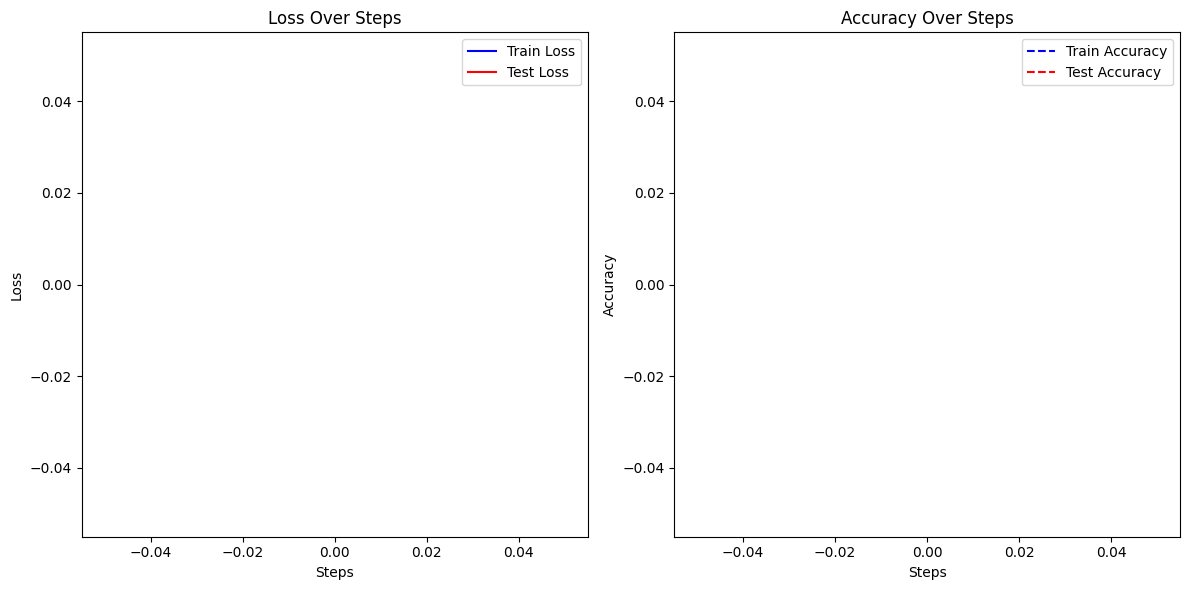

[1,   100,     99] LR: 0.00100
[1,   100] loss: 3.94670, acc: 10.96094


KeyboardInterrupt: 

In [ ]:
train_mlp(71773, 256, train_loader=train_loader, test_loader=test_loader,
        net=mlp_model2, lr_scheduler=lr_scheduler, optimizer=optimizer)

In [ ]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fruits-360"
input_type = "Linearized Images"
model_name = "MLP"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(mlp_model2, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(mlp_model2, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

In [ ]:
results_df.to_csv('results2.csv', index=False)

### 3. DeepConvNet on Images

#### Load Data with Augmentation

#### Define Model and Optimizers

#### Train and Evaluate

### 4. Finetune Pretrained Models

#### Load Data

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),     # Convert to tensor and scale to [0, 1]
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])  # Normalize for RGB channels
])

# Load the dataset
train_images = datasets.ImageFolder(root='./data/fruits-360/train', transform=transform)
test_images = datasets.ImageFolder(root='./data/fruits-360/test', transform=transform)

train_loader = DataLoader(train_images, batch_size=256, shuffle=True)
test_loader = DataLoader(test_images, batch_size=256, shuffle=False)

print(f'Size of training images {len(train_images)}')
print(f'Size of training labels {len(test_images)}')



Size of training images 71773
Size of training labels 24051


In [489]:
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_images), 'val': len(test_images)}
print(dataset_sizes)

{'train': 71773, 'val': 24051}


#### Define Model and Optimizer

In [490]:
# Pretrained model
resnet18_model = resnet18(pretrained=True) 
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, len(fruits))

model_ft = resnet18_model.to(device)

lr_init = 0.001              # initial learning rate
lr_factor = 0.01             # learning rate decay factor
weight_decay_factor = 1e-4   # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft, milestones=lr_schedule_milestones, gamma=lr_factor)

#### Train and Evaluate

In [491]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 3.0202 Acc: 0.3638
val Loss: 2.3746 Acc: 0.4514

Epoch 1/19
----------


KeyboardInterrupt: 

In [ ]:
plot_loss_and_accuracy_side_by_side(train_loss_fn[:20], val_loss_fn[:20], train_acc_fn[:20], val_acc_fn[:20], range(20), 20)

In [ ]:
# Exemplar pentru experiment cu Fashion Dataset, Atribute, și MLP
dataset_name = "Fruits-360"
input_type = "Liniarized Images"
model_name = "Finetuned ResNet18"

# Calculăm metricile pentru seturile de antrenare și test
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(model_ft, train_loader, device)
test_precision, test_recall, test_f1, test_accuracy = evaluate_model(model_ft, test_loader, device)

# Adăugăm rezultatele în tabel
results.append({
    "Dataset": dataset_name,
    "Input Type": input_type,
    "Model": model_name,
    "Data Split": "Test",
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Accuracy": test_accuracy
})

# Conversia listei de rezultate într-un DataFrame
results_df = pd.DataFrame(results)

# Afișăm tabelul complet
results_df.style.hide()

In [ ]:
results_df.to_csv('results2.csv', index=False)